In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [21]:
#sample data sets

X_train = np.random.uniform(-1, 1, (5, 200)) #25, 20, 5
Y_train = np.random.uniform(0, 1, (2, 200)) # 25, 20, 2

In [15]:
# create the class FFN:
# a time stepper that takes in (input_data, output_data, hidden_layers (list), activation_function (list of tuples), epochs, learning rate, batch_size)
# going to assume mean squared error and stochastic gradient descent.
class FFN:
    def __init__(self, input_data, output_data, hidden_layers, activation_functions, epochs, learning_rate, batch_size):
        self.input_data = input_data ## make sure this is a numpy array
        self.output_data = output_data
        self.hidden_layers = hidden_layers
        self.activation_functions = activation_functions
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.weights_dictionary = {}
        self.activations_dictionary = {}
        self.initialize()


    def initialize(self):
        last_layer = self.input_data.shape[0]
        for i in range(len(self.hidden_layers)):
            #print(i)
            self.weights_dictionary[f'w{i}'] = 0.1 * np.random.randn(self.hidden_layers[i], last_layer)
            self.weights_dictionary[f'b{i}'] = np.zeros((self.hidden_layers[i], 1))
            last_layer = self.hidden_layers[i]
        self.weights_dictionary['last_weight'] = 0.1 * np.random.randn(self.output_data.shape[0], last_layer)
        self.weights_dictionary['last_bias'] = np.zeros((self.output_data.shape[0], 1))
        
                
    def forward(self, input_batch): #setting up to be called within the training method for each batch
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.weights_dictionary[f'w{i}'], input_batch) + self.weights_dictionary[f'b{i}'] # so weights of first layer are 
            #print(f' input {input_batch.shape}', f"biases {self.weights_dictionary[f'b{i}'].shape}", f"weights {self.weights_dictionary[f'w{i}'].shape}")
            a = self.activation(z, self.activation_functions[i]) # should have shape (neurons in layer 1, batch size)
            self.activations_dictionary[f'z{i + 1}'] = z #activation (prefunction) of the first hidden layer is added as z1 
            self.activations_dictionary[f'a{i + 1}'] = a #activation of first layer added as a1
            input_batch = a
        #print(f'weights {self.weights_dictionary["last_weight"].shape}', f'input {input_batch.shape}', f'biases {self.weights_dictionary["last_bias"].shape}')   
        a = np.dot(self.weights_dictionary['last_weight'], input_batch) + self.weights_dictionary["last_bias"]
        self.activations_dictionary['activation_output'] = a
        
        ## so much cleaner instead of having to index a load of lists and potentially reverse them etc.
        
    def activation(self, a, activation_function):
        if activation_function[0] == "relu":
            return np.maximum(0, a)
        elif activation_function[0] == "sigmoid":
            return 1 / (1 + np.exp(-a))
        elif activation_function[0] == "tanh":
            return np.tanh(a)
        elif activation_function[0] == "lrelu": # THink about how you can have an alpha parameter when you want it 
            return np.maximum(activation_function[1] * a, a) 
        else:
            raise Exception("Invalid activation function")

    def activation_derivative(self, a, activation_function): # check this you should remember what function you had
        
        if activation_function[0] == 'relu':
            return np.where(a > 0, 1, 0)
        elif activation_function[0] == 'sigmoid':
            sig = self.activation(a, ('sigmoid', 0))
            return sig * (1 - sig)
        elif activation_function[0] == 'tanh':
            return 1 - np.tanh(a)**2
        elif activation_function[0] == 'lrelu':
            dx = np.ones_like(input)
            dx[a <= 0] = activation_function[1]   # THink about how you can have an alpha parameter when you want it 
            return dx
        
        else:
            raise Exception("Invalid activation function derivative")

    def backward(self, dvalues, input_batch): ## just need the dictionary key for the output activations and the output batch
        ## computing the loss gradient here
        i = len(self.hidden_layers)
        #print( f'loss gradients shape {dvalues.shape}', f"output {self.activations_dictionary[f'a{i}'].T.shape}")
        self.weights_dictionary["dweights last_weight"] = np.dot(dvalues, self.activations_dictionary[f'a{i}'].T) #if this dont work switch them...
        self.weights_dictionary["dbiases last_bias"] = np.sum(dvalues, axis = 1, keepdims=True)
        dinputs = np.dot(self.weights_dictionary["dweights last_weight"].T, dvalues)
        #print(f"dweights shape{self.weights_dictionary[f'dweights last_weight'].shape}", f"dbias shape{self.weights_dictionary[f'dbiases last_bias'].shape}", f"dinputs shape{dinputs.shape}")
        # for i in range(len(self.hidden_layers), 0, -1):
        #     print(i)
        #     self.weights_dictionary[f'dweights{i-1}'] = np.dot(dinputs, self.activations_dictionary[f'a{i-1}'].T)
        #     self.weights_dictionary[f'dbiases{i-1}'] = np.sum(dinputs, axis = 0, keepdims=True)
        #     dinputs = np.dot(self.weights_dictionary[f'dweights{i-1}'].T, dinputs)
        #     dinputs *= 
        #     print(f"dweights shape{self.weights_dictionary[f'dweights{i-1}'].shape}", f"dbias shape{self.weights_dictionary[f'dbiases{i-1}'].shape}", f"dinputs shape{dinputs.shape}")

        for i in range(len(self.hidden_layers)-1, -1, -1):
            dinputs *= self.activation_derivative(self.activations_dictionary[f'z{i+1}'], self.activation_functions[i])
            self.weights_dictionary[f'dweights{i}'] = np.dot(dinputs, self.activations_dictionary[f'a{i}'].T if i > 0 else input_batch.T)  # Added condition for input_batch
            self.weights_dictionary[f'dbiases{i}'] = np.sum(dinputs, axis=1, keepdims=True)
            if i > 0:
                dinputs = np.dot(self.weights_dictionary[f'w{i}'].T, dinputs)
            #print(f"dweights shape{self.weights_dictionary[f'dweights{i}'].shape}", f"dbias shape{self.weights_dictionary[f'dbiases{i}'].shape}", f"dinputs shape{dinputs.shape}")

        
        
    def compute_loss(self, predictions, targets):
        return np.mean((predictions - targets) ** 2) # the loss function averaged out for normalisation
        



    def loss_backwards(self, predictions, targets):
        return 2 * (predictions - targets) / len(targets) # the loss function averaged out for normalisation






    def train(self):
        epoch_data = []
        loss_history = []
        for epoch in range(self.epochs):
            for start in range(0, self.input_data.shape[1], self.batch_size):
                start = start
                end = start + self.batch_size
                #print(f'end {end}')
                input_batch = self.input_data[:,start:end]
                #print(f'batchinputs {input_batch.shape}')
                output_batch = self.output_data[:,start:end]
                #print(f'batchoutputs {output_batch.shape}')
            
                 # should be minibatches but for now no
                 # same here
                self.forward(input_batch)
                loss = self.compute_loss(self.activations_dictionary["activation_output"], output_batch) # should be a function calling usual MSE
                dvalues = self.loss_backwards(self.activations_dictionary["activation_output"], output_batch)
                self.backward(dvalues, input_batch)
                self.update()
    
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
                epoch_data.append(epoch)
                loss_history.append(loss)

        plt.plot(epoch_data, loss_history)
        plt.xlabel("Iteration Number")
        plt.ylabel("Loss")
        plt.title("Iteration Number vs Loss")
        plt.show()
        
    def update(self):
        for i in range(0, len(self.hidden_layers)):
            self.weights_dictionary[f'w{i}'] -= self.learning_rate * self.weights_dictionary[f'dweights{i}']
            self.weights_dictionary[f'b{i}'] -= self.learning_rate * self.weights_dictionary[f'dbiases{i}']
        self.weights_dictionary["last_weight"] -= self.learning_rate * self.weights_dictionary["dweights last_weight"]
        self.weights_dictionary["last_bias"] -= self.learning_rate * self.weights_dictionary["dbiases last_bias"]
        

        

Epoch 0, Loss: 0.03319978326593326
Epoch 100, Loss: 0.027589885878924032
Epoch 200, Loss: 0.02758998705922787
Epoch 300, Loss: 0.02759004049549319
Epoch 400, Loss: 0.0275900714330976
Epoch 500, Loss: 0.027590090059636536
Epoch 600, Loss: 0.027590101295467462
Epoch 700, Loss: 0.027590108163126313
Epoch 800, Loss: 0.027590112430533553
Epoch 900, Loss: 0.02759011512478826
Epoch 1000, Loss: 0.027590116850174085
Epoch 1100, Loss: 0.027590117966106102
Epoch 1200, Loss: 0.027590118688553062
Epoch 1300, Loss: 0.02759011914924399
Epoch 1400, Loss: 0.027590119429900334
Epoch 1500, Loss: 0.02759011958235058
Epoch 1600, Loss: 0.027590119640385873
Epoch 1700, Loss: 0.027590119627138886
Epoch 1800, Loss: 0.027590119557875895
Epoch 1900, Loss: 0.027590119444397487


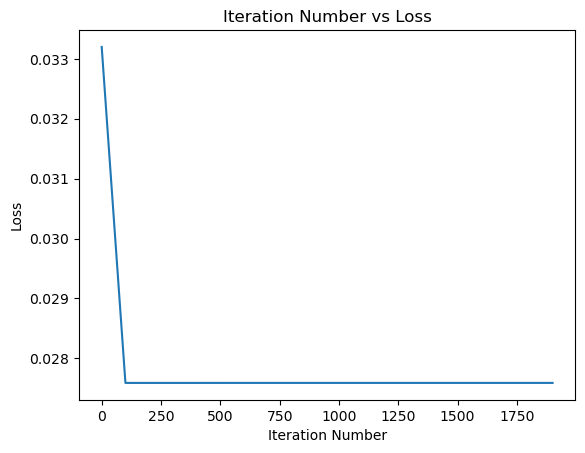

In [23]:
tester = FFN(X_train, Y_train, [30, 30], [("sigmoid", 0), ("relu", 0)], 2000, 0.01, 2)
#tester.backward(tester.activation_derivative(Y_train, tester.activation_functions[0]))
tester.train()